# Tutorial: Coding an AutoEncoder in Tensorflow

What is an AutoEncoder?

Blablabla explanation

***
Let's first import some useful libraries:

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"


***
Let's also import the training set

In [16]:
mnist = tf.keras.datasets.mnist
(X_train, _), (X_test, _) = mnist.load_data()

Draw a sample


 Sample: 



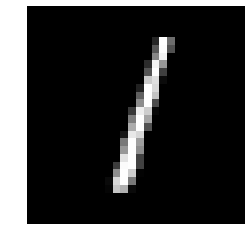

In [17]:
sample = 2

X_train = X_train.astype(np.float32).reshape(-1,28*28)/X_train.max()
X_test = X_test.astype(np.float32).reshape(-1,28*28)/X_train.max()

print('\n Sample: \n')
plt.imshow(X_test[sample].reshape(28,28), cmap='gray');
plt.axis('off');


## Layer class definition

In [18]:
class Layer(object):
    
    def __init__(self, mi, mo, name):
        
        """
        This is the init method of the class Layer:
        It defines the class itself and contains the
        definition of the parameters that will be used by
        the other class' methods (i.e. forward)
        
        """
        # we are creating a dense layer, it's trainable parameters
        # are the matrix W of dimensions (mi, mo) and the biases
        # vectors that has dimension (mo)
        
        self.W = tf.get_variable(name='W_%s' %name,        # this name identifies uniquely the matrix W
                                 shape=(mi, mo),           # this assigns to the matrix the needed shape
                                 initializer=tf.glorot_uniform_initializer()) # you can choose among
                                                                              # many different distributions
                                                                              # to initialize your weights with
        
        self.b = tf.get_variable(name="b_%s" %name,        # this name identifies uniquely the bias vector b 
                                 shape=(mo,),              
                                 initializer=tf.zeros_initializer(),) # biases can be initialized as zeros
        
    def forward(self,X):
        
        """
        This is the forward propagation method of the class Layer
        """
        # the method forward performs the following forward propagation 
        # operation on the input tensor X. Don't worry about back  
        # propagation, tensorflow will handle it
        
        Z=tf.matmul(X,self.W)+self.b
        
        return Z
        
        
        
    def set_session(self, session):
        
        """
        this is needed to set the tensorflow session (more about this later)
        """
        
        self.session = session
        

## Creating the AutoEncoder Network

Blablabla

In [19]:
class AutoEncoder(object):
    
    def __init__(self, input_dim, layer_dims):
        
        """
        The AutoEncoder (AE) class is initialized by providing the number of features of the 
        input (in this case 28*28) and a list of integers named layers_dims.
        It contains the number of the nodes for the intermediate layers and is of the kind:
        
        layer_dims= [
                     output_nodes_layer_1,
                     output_nodes_layer_2,
                     output_nodes_layer_3,
                     ...
                     output_nodes_layer_n
                     ]
                     
        """
        # Write code here
        self.layer_dims = layer_dims #Note: all of what has self in front of it will be reused outside the init method!
        
        """
        
        The AE architecture has a butterfly shape and thus we reverse the previous 
        list of shapes to obtain:
        
        reversed_layer_dims = [
                               output_nodes_layer_(n-1),
                               output_nodes_layer_(n-2),
                               ...
                               output_nodes_layer_2,
                               output_nodes_layer_1,
                               ]
        """
        # Write code here
        self.reversed_layer_dims= list(reversed(layer_dims))[1:] #Note: We exclude layer n
        
        """
        
        Now we define the placeholder for our input tensor X_in, and create 2 empty lists
        named encoder_layers and decoder_layers that will contain the layers of our AE
        
        """
        
        #Write code here
        self.X_in = tf.placeholder(tf.float32, shape=(None, input_dim))
        
        self.encoder_layers = []
        self.decoder_layers = []
        
        
        """
        
        We miss one last ingredient to build our AE: a method that build the network in fact, 
        and it will be called build network
        
        
        """
        # Write code here
        self.build_network(input_dim)
        
    
    """
    Let's define what this build network method does:
    
    """
    def build_network(self, input_dim):
        
        # Write code here
        
        mi = input_dim
        count=0
        for mo in self.layer_dims:
            layer = Layer(mi, mo, count)
            self.encoder_layers.append(layer)
            count+=1
            mi = mo
            
        
        for mo in self.reversed_layer_dims:         
            layer = Layer(mi, mo, count)
            self.decoder_layers.append(layer)
            mi = mo
            count+=1
        
        output_layer = Layer(mi,input_dim, count)
        self.decoder_layers.append(output_layer)
        
    
        """
        
        
        
        
        """
    
        self.Z = self.encode(self.X_in)
        logits = self.decode(self.Z)
        self.X_hat = tf.nn.sigmoid(logits)    
        
        """
        
        
        """
        
        self.cost = tf.reduce_sum(
                    tf.nn.sigmoid_cross_entropy_with_logits(
                        labels=self.X_in,
                        logits=logits
                    )
                 )

        # make the trainer
        self.train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.cost)

    def encode(self, X):
        
        output=X
        
        for layer in self.encoder_layers:
            
            output = layer.forward(output)
            #output = tf.nn.sigmoid(output)
            
        return output
        
    def decode(self,Z):
        
        output=Z
        
        for layer in self.decoder_layers[:-1]:
            
            output = layer.forward(output)
            output = tf.nn.sigmoid(output)
            
        output = self.decoder_layers[-1].forward(output)
        return output
    
    def set_session(self, session):
        
        self.session = session
        for layer in self.encoder_layers:
            layer.set_session(session)  
        for layer in self.decoder_layers:
            layer.set_session(session) 
        
    def fit(self, X, 
            epochs=10,
            batch_size=100,
            
            show_fig=True):
        
        costs = []
        n_batches = len(X) // batch_size
        
        print("Training AutoEncoder")
        print("n_batches:", n_batches)
        for i in range(epochs):
            
            print("epoch:", i)
            np.random.shuffle(X)
        
            for j in range(n_batches):
            
                X_batch = X[j*batch_size:(j+1)*batch_size]
                _, c, = self.session.run((self.train_op, self.cost), feed_dict={self.X_in: X_batch})
                c /= batch_size # just debugging

                costs.append(c)
        
                if j % 10*batch_size == 0:

                    print("iter: %d, cost: %.3f" % (j, c))
            
                #if show_fig:
                #    plt.plot(costs)
                #    plt.show()
                #    plt.clf()


    def predict(self, X):
        
        return self.session.run(self.X_hat, feed_dict={self.X_in: X})




In [20]:
def test_single_autoencoder():
    
    
    N, D = X_train.shape

    tf.reset_default_graph()
    
    dae = AutoEncoder(D, [500,300,100])

    
    init_op=tf.global_variables_initializer()
    
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.10)
    
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options )) as sess:
  # plot reconstruction
        
        sess.run(init_op)
        dae.set_session(sess)
        
        dae.fit(X_train)

        done = False
        while not done:
            i = np.random.choice(len(X_test))
            x = X_test[i]
            y = dae.predict([x]).reshape(28, 28)

            plt.subplot(1,2,1)
            plt.imshow(x.reshape(28, 28), cmap='gray')
        
            plt.title("Original")
            plt.subplot(1,2,2)
            plt.imshow(y, cmap='gray')
            plt.title("Reconstruction")
            plt.show()

            ans = input("Generate another?")
            if ans and ans[0] in ('n' or 'N'):
                  done = True

Training AutoEncoder
n_batches: 600
epoch: 0
iter: 0, cost: 570.664
iter: 10, cost: 232.799
iter: 20, cost: 218.195
iter: 30, cost: 212.287
iter: 40, cost: 194.430
iter: 50, cost: 198.262
iter: 60, cost: 205.279
iter: 70, cost: 203.191
iter: 80, cost: 193.451
iter: 90, cost: 200.016
iter: 100, cost: 197.902
iter: 110, cost: 198.744
iter: 120, cost: 188.396
iter: 130, cost: 191.078
iter: 140, cost: 178.965
iter: 150, cost: 190.843
iter: 160, cost: 169.539
iter: 170, cost: 170.868
iter: 180, cost: 169.030
iter: 190, cost: 167.918
iter: 200, cost: 158.225
iter: 210, cost: 168.048
iter: 220, cost: 166.693
iter: 230, cost: 159.281
iter: 240, cost: 157.274
iter: 250, cost: 152.310
iter: 260, cost: 145.608
iter: 270, cost: 146.601
iter: 280, cost: 148.816
iter: 290, cost: 146.386
iter: 300, cost: 138.535
iter: 310, cost: 142.636
iter: 320, cost: 146.241
iter: 330, cost: 151.553
iter: 340, cost: 139.143
iter: 350, cost: 140.523
iter: 360, cost: 143.569
iter: 370, cost: 137.038
iter: 380, cost:

iter: 480, cost: 68.120
iter: 490, cost: 64.826
iter: 500, cost: 60.769
iter: 510, cost: 63.683
iter: 520, cost: 64.409
iter: 530, cost: 62.812
iter: 540, cost: 63.139
iter: 550, cost: 64.849
iter: 560, cost: 62.708
iter: 570, cost: 63.453
iter: 580, cost: 63.294
iter: 590, cost: 65.253
epoch: 6
iter: 0, cost: 66.116
iter: 10, cost: 64.052
iter: 20, cost: 61.552
iter: 30, cost: 66.158
iter: 40, cost: 64.284
iter: 50, cost: 66.334
iter: 60, cost: 62.778
iter: 70, cost: 64.646
iter: 80, cost: 67.158
iter: 90, cost: 64.077
iter: 100, cost: 65.660
iter: 110, cost: 62.681
iter: 120, cost: 64.183
iter: 130, cost: 64.762
iter: 140, cost: 63.976
iter: 150, cost: 64.945
iter: 160, cost: 63.915
iter: 170, cost: 65.988
iter: 180, cost: 66.242
iter: 190, cost: 64.642
iter: 200, cost: 63.758
iter: 210, cost: 64.612
iter: 220, cost: 68.571
iter: 230, cost: 65.258
iter: 240, cost: 63.516
iter: 250, cost: 65.932
iter: 260, cost: 63.879
iter: 270, cost: 65.474
iter: 280, cost: 61.474
iter: 290, cost: 6

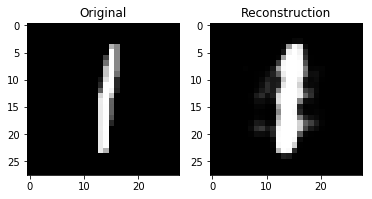

Generate another?


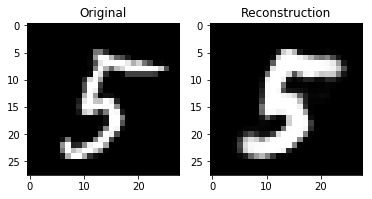

Generate another?


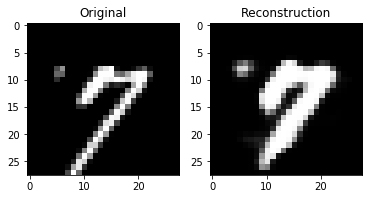

Generate another?


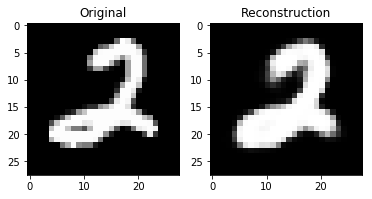

Generate another?n


In [21]:
if __name__ == '__main__':
    test_single_autoencoder()
